# I. Business Objective:

Urban Wear, a clothing brand, is preparing to launch its eCommerce store. In anticipation of the launch, the brand has set up a pre-launch page to collect emails from potential customers. The goal is to maximize the number of email sign-ups before the official launch. To achieve this, Urban Wear is conducting an A/B test to determine whether changing the color of the submit button on the sign-up form will result in more sign-ups.

The control version of the pre-launch page features a blue submit button, while the treatment version features a green submit button. 

Task is to design, execute, and analyze the A/B test to help the product team decide which button color to use.

In [1]:
# Importing the necessary libraries
from datetime import datetime
import random
import math
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from matplotlib.ticker import MultipleLocator 

# Disabling warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Loading datasets
pretest = pd.read_csv('pretest.csv')
print('Pretest Data Imported')
test = pd.read_csv('test.csv')
print('Test Data Imported')

# Setting date fields as datetime objects
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])

Pretest Data Imported
Test Data Imported


# II. Exploratory Data Analysis:

In [3]:
pretest.head()

visitor_id       date email experiment  group  submitted
0           1 2021-12-01   NaN        NaN    NaN          0
1           2 2021-12-01   NaN        NaN    NaN          0
2           3 2021-12-01   NaN        NaN    NaN          0
3           4 2021-12-01   NaN        NaN    NaN          0
4           5 2021-12-01   NaN        NaN    NaN          0

### Overview of the Pretest Table 

In [4]:
print('Number of rows:', pretest.shape[0])
print('Date range:', pretest.date.min(), '-', pretest.date.max())

Number of rows: 309903
Date range: 2021-12-01 00:00:00 - 2021-12-31 00:00:00


### Checking for Missing Data

In [5]:
(pretest.isnull().mean()*100).round(2)

visitor_id     0.00
date           0.00
email         89.90
experiment    90.31
group         90.31
submitted      0.00
dtype: float64

### Pretest Performance Summary

Let's try to understand these questions:
1. How many visitors were there?
2. How many sign-ups were there
3. What was the sign-up rate?

In [6]:
print('Total visitor count:', pretest.visitor_id.nunique())
print('Sign-up count:', pretest.submitted.sum())
print('Sign-up rate:', pretest.submitted.mean().round(2))

Total visitor count: 309903
Sign-up count: 31295
Sign-up rate: 0.1


### Plot Visitor per Day

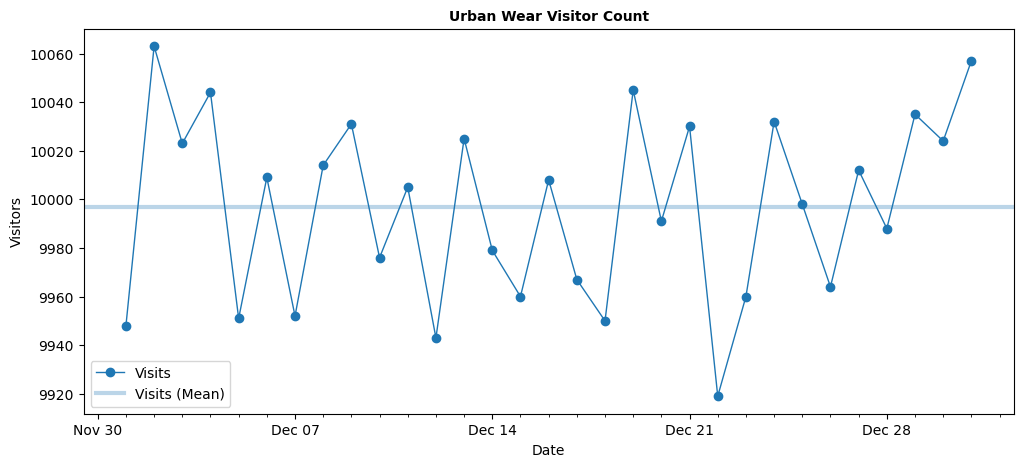

In [7]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Count sign-ups by date
visits_per_day = pretest.groupby('date')['submitted'].count()
visits_mean = visits_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(visits_per_day.index, visits_per_day, '-o', color=c1, linewidth=1, label='Visits')
plt.axhline(visits_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Visits (Mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Urban Wear Visitor Count', fontsize=10, weight='bold')
plt.ylabel('Visitors', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()

plt.show()

### Plot Sign-Up Rate per Day

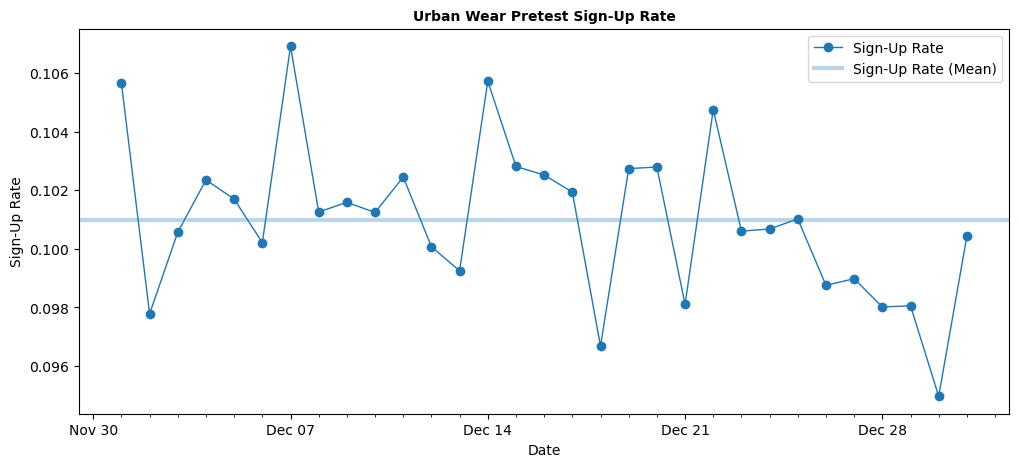

In [8]:
# Get the submission rate per date
signup_rate_per_day = pretest.groupby('date')['submitted'].mean() 
signup_rate_mean = signup_rate_per_day.mean() 

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, '-o', color=c1, linewidth=1, label='Sign-Up Rate')
plt.axhline(signup_rate_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Sign-Up Rate (Mean)')

# Format plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Urban Wear Pretest Sign-Up Rate', fontsize=10, weight='bold')
plt.ylabel('Sign-Up Rate', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()
plt.show()

# III. Stating the Hypothesis

In this experiment, we are interested in comparing the sign-up rates between two different button colors: blue and green.

**Null Hypothesis (H₀):** The sign-up rates of blue and green buttons are the same.

**Alternative Hypothesis (H₁):** The sign-up rates of blue and green buttons are different.

Next, we will set the parameter values for the experiment, including the significance level (alpha), statistical power, and minimum detectable effect (MDE).

In [9]:
# Experiment parameters
alpha = 0.05  # Setting the significance value at 0.05. If the p-value is less than 0.05, reject Ho.
power = 0.80  # Ensuring that there's 80% chance of detecting an effect with significance
mde = 0.10    # Detecting a 10% improvement of the sign-up rate with statistical significance

# Proportions if the effect exists
p1 = 0.10           # Control   (Blue)
p2 = p1 * (1 + p1)  # Treatment (Green)

# IV. Designing the Experiment

The design of the experiment involves determining the randomization unit, calculating the sample size, and determining the experiment duration. In this section, we will explore how to calculate the sample size and experiment duration.

### Sample Size Calculation
To figure out how many samples we need in our experiment, we follow these steps:

1. **Calculate the Effect Size**:
   - The effect size tells us how big the difference is between two groups (like a control group and a treatment group). It helps us understand the size of the change we expect to see.

2. **Estimate the Required Sample Size**:
   - Next, we calculate how many samples are needed in each group to be confident that our experiment will detect a real difference if it exists. We consider the desired statistical power (usually 80%) and the significance level (typically 5%), which is the chance of making a Type I error (saying there is a difference when there isn't).
   - We then round the sample size to the nearest thousand for practicality. The total sample size for the experiment is calculated by adding the samples needed for both groups.

3. **Check the Power Across Different Sample Sizes**:
   - We create a graph to visualize how the statistical power changes as the sample size increases. This helps us see if our chosen sample size will give us enough power to detect a meaningful effect.
   - We add reference lines to the graph to indicate the desired power level and the sample size we've calculated. This ensures that our experiment is well-designed to provide reliable results.

By following this process, we make sure we have enough samples to confidently detect differences in the experiment without using more samples than necessary.

To detect an effect of 10.0% lift from the pretest sign-up at 10%, the sample size per group required is 15000.
The total sample required in the experiment is 30000.


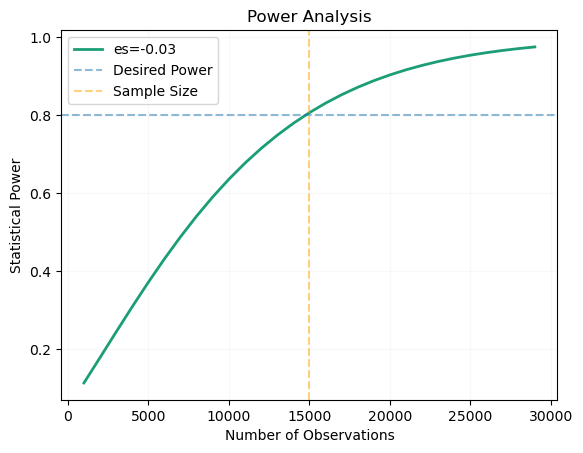

In [10]:
# Calculate the effect size using Cohen's D
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# Estimate the sample size required per group
ttest_power = TTestIndPower()
n = ttest_power.solve_power(effect_size=cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from the pretest sign-up at {100*p1:.0f}%, '
      f'the sample size per group required is {n}.'
      f'\nThe total sample required in the experiment is {2*n}.')

# Explore power across sample sizes
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(n, linestyle='--', color='orange', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

### Experiment Duration Analysis

In this section, we calculate the duration required to achieve the necessary sample size for the experiment based on different traffic allocations and evaluate the required daily traffic for different experiment durations.

1. **Duration Based on Traffic Allocation**:
   - We calculate how long the experiment will need to run to achieve the required sample size, depending on the percentage of unique visitors allocated to the experiment each day.
   - By plotting the relationship between traffic allocation (as a percentage of daily visitors) and the number of days needed, we can see how increasing the allocation reduces the experiment duration.

2. **Duration Based on Traffic Volume**:
   - We also calculate the experiment duration based on the actual number of unique visitors allocated to the experiment each day.
   - A plot shows how many days are needed depending on the number of daily visitors allocated to the experiment, allowing us to plan according to available traffic.

3. **Required Users per Day for Specific Experiment Durations**:
   - We estimate how many users would be needed each day to complete the experiment within specific timeframes (e.g., 21 days, 14 days, 7 days).
   - This helps us understand the trade-offs between the length of the experiment and the required daily traffic, balancing the need for timely results with statistical reliability.

This analysis helps us determine the optimal experiment duration based on traffic allocation and ensures that we can achieve the necessary sample size within a practical timeframe.

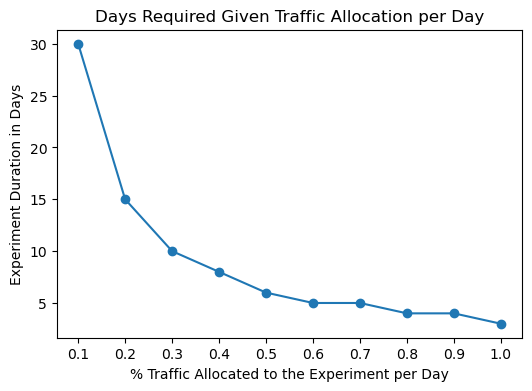

In [11]:
# what's the duration required to achieve the required sample size given the 
# percentage of unique visitors allocated to the experiment?

alloc = np.arange(0.10,1.1,0.10)
size = round(visits_mean, -3) * alloc
days = np.ceil(2*n / size)

# Generate plot
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(alloc, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('% Traffic Allocated to the Experiment per Day')
plt.show()

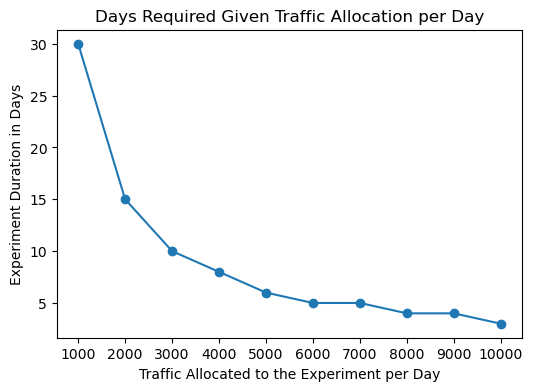

In [12]:
# what's the duration required to achieve the required sample size given the 
# number of unique visitors allocated to the experiment?

f, ax = plt.subplots(figsize=(6, 4))
ax.plot(size, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('Traffic Allocated to the Experiment per Day')
plt.show()

In [13]:
# Displaying the number of users required per day in an experiment given the experiment duration.
print(f'For a 21-day experiment, {np.ceil(n * 2 / 21)} users are required per day') # Too long to wait
print(f'For a 14-day experiment, {np.ceil(n * 2 / 14)} users are required per day') # Sweet spot between risk and time
print(f'For a 7-day experiment, {np.ceil(n * 2 / 7)} users are required per day')   # Too risky

For a 21-day experiment, 1429.0 users are required per day
For a 14-day experiment, 2143.0 users are required per day
For a 7-day experiment, 4286.0 users are required per day
